In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1, j0, sici

## Parameters for testing from the paper

In [32]:
# compute for homogenous contrast
rho_solv = 1
rho_s = rho_solv+1
rho_c = rho_solv+1

# Example (units in Å)
Vc = 4000
Vs = 4000
R = 40
L = [200, 400, 1000, 10000]
N = 67
Rg = 10
d = 1.0
V_total = N*(Vs+Vc) 

## Utility functions

In [33]:
def ff_debye_chain(q,rg):
    u = np.power(q*rg, 2.0)
    u2=u*u
    u3=u2*u
    u4=u2*u2
    res = np.zeros_like(u)
    small_vals = np.fabs(u)<=1e-4
    res[small_vals] = 1.0-(u[small_vals]/3.0) + \
        (u2[small_vals]/12.0)- \
            (u3[small_vals]/60.0) + \
    (u4[small_vals]/360.0)

    res[~small_vals] = 2 * (np.exp(-u[~small_vals]) - 1 + u[~small_vals]) / (u2[~small_vals])

    return res 

def ff_chain_amplitude(q, rg):
    """Compute form factor of the chain

    There seems to be some discrepency in the paper about whether psi(qRg) or psi(qRg^2) is used.
    SASFit uses qRg^2 while the equation 5 in Pedersen paper uses psi(qRg)
    """
    u = np.power(q*rg, 2.0) 
    u2=u*u
    res = np.zeros_like(u)
    small_vals = np.fabs(u)<=1e-4
    res[small_vals] = (1 - u[small_vals]/10. + u2[small_vals]/60.)/(1. + (2.*u[small_vals])/5 + u2[small_vals]/20.)
    res[~small_vals] = (1 - np.exp(-u[~small_vals])) / u[~small_vals]

    return res

def J1x_x(q, r):
    u = q*r 
    res = np.ones_like(u)*0.5
    res[u>1e-4] = j1(u[u>1e-4])/u[u>1e-4]
    
    return res 

## Final kernel

In [34]:
def micelle_longcylinder_kernel(q,
        v_core=None,
        v_corona=None,
        v_total=None,
        sld_solvent=None,
        sld_core=None,
        sld_corona=None,
        radius_core=None,
        rg=None,
        length_core=None,
        d_penetration=None,
        n_aggreg=None):
    
    v_total = n_aggreg*(v_core+v_corona)
    rho_solv = sld_solvent     # sld of solvent [1/A^2]
    rho_core = sld_core        # sld of core [1/A^2]
    rho_corona = sld_corona    # sld of corona [1/A^2]

    beta_core = v_core * (rho_core - rho_solv)
    beta_corona = v_corona * (rho_corona - rho_solv)

    # Self-correlation term of the core
    ff_crossec = 2*J1x_x(q, radius_core)
    ff_thinrod_term1 = (sici(q*length_core)[0])/(q*length_core)
    ff_thinrod_term2 = np.sin(0.5*q*length_core)/(0.5*q*length_core)
    ff_thinrod = (2*ff_thinrod_term1) - np.power(ff_thinrod_term2, 2)
    ff_thinrod[q<=1e-4] = 1.0

    Fs = np.power(ff_crossec, 2.0)*ff_thinrod
    term1 = np.power(n_aggreg*beta_core, 2)*Fs 

    # Self-correlation term of the chains
    debye_chain = ff_debye_chain(q,rg)
    term2 = n_aggreg * (beta_corona**2) * debye_chain

    # Interference cross-term between core and chains
    chain_ampl = ff_chain_amplitude(q, rg)
    ff_chain = j0(q*(radius_core + (d_penetration*rg)))
    Ssc = chain_ampl*ff_crossec*ff_chain*ff_thinrod
    term3 = 2.0 * (n_aggreg**2) * beta_core * beta_corona * Ssc

    # Interference cross-term between chains
    Scc = (chain_ampl**2) * (ff_chain**2) * ff_thinrod
    term4 = n_aggreg * (n_aggreg - 1.0)* (beta_corona**2)*Scc

    # I(q)_micelle : Sum of 4 terms computed above
    i_micelle = term1 + term2 + term3 + term4

    # Normalize intensity by total volume
    return i_micelle, v_total, term1, term2, term3, term4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Length : 200 Å 
Length : 400 Å 
Length : 1000 Å 
Length : 10000 Å 


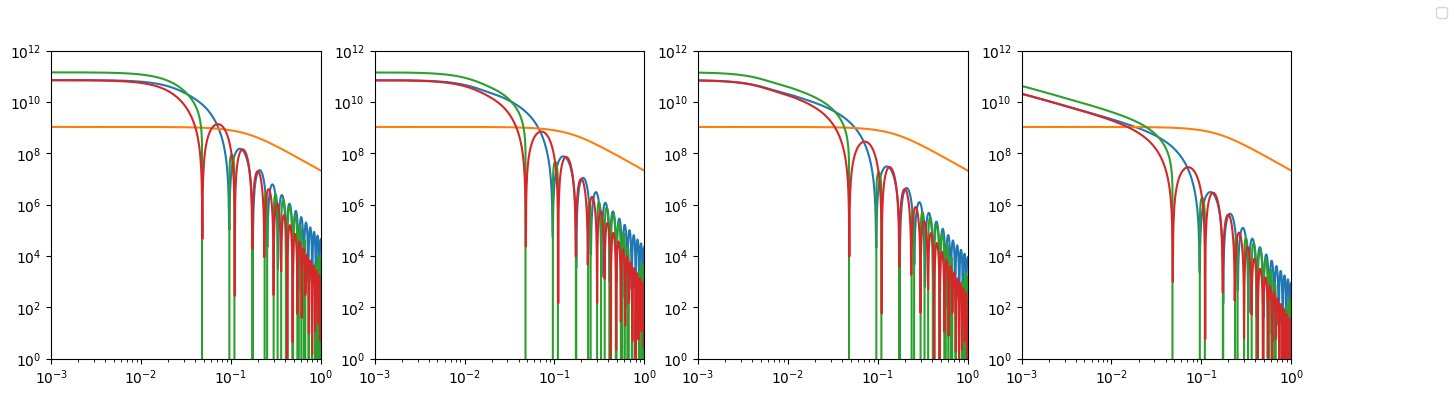

In [35]:
linestyles = ['dashed','dotted','dashdot', 'solid']
fig, axs = plt.subplots(1,4, figsize=(4*4, 1*4))
for i in range(4):
    print('Length : %d Å '%L[i])
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'v_total' : V_total,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'length_core': L[i],
            'd_penetration':d,
            'n_aggreg' : N,
            }
    q = np.logspace(np.log10(1e-4), np.log10(1), 1000)
    terms = micelle_longcylinder_kernel(q, **params)
    for j in range(4):
        axs[i].loglog(q, terms[j+2])
        axs[i].set_xlim([1e-3, 1e0])
        axs[i].set_ylim([1e0, 1e12])
fig.legend()
plt.show()

In [36]:
for i in range(4):
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'v_total' : V_total,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'length_core': L[i],
            'd_penetration':d,
            'n_aggreg' : N,
            }
    q = np.asarray([1e-3])
    out = micelle_longcylinder_kernel(q, **params)
    print('Intesnity at Length : %d Å '%L[i], '%E'%(out[0]/out[1]))

Intesnity at Length : 200 Å  5.349415E+05
Intesnity at Length : 400 Å  5.331701E+05
Intesnity at Length : 1000 Å  5.210061E+05
Intesnity at Length : 10000 Å  1.593327E+05


## Example to compare with the paper qualitatively 

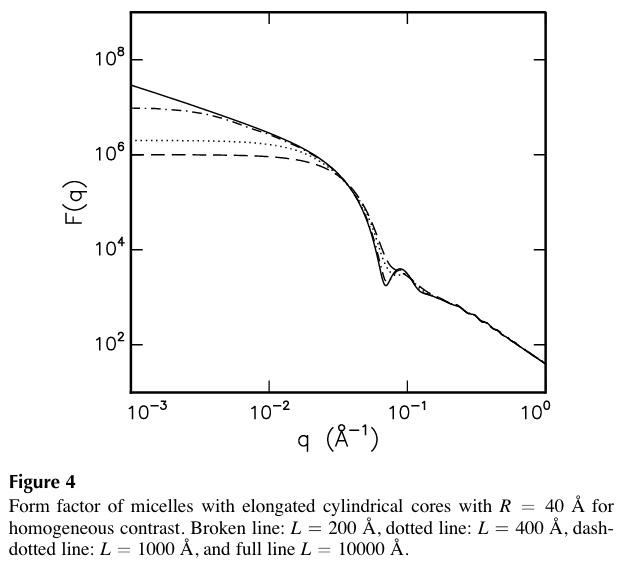

Length : 200 Å 
Length : 400 Å 
Length : 1000 Å 
Length : 10000 Å 


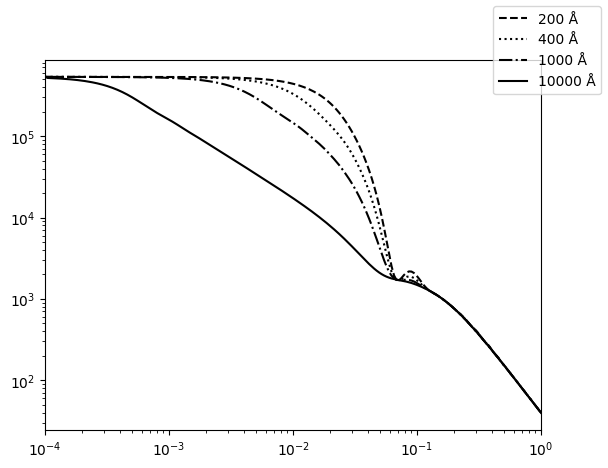

CPU times: user 706 ms, sys: 123 ms, total: 829 ms
Wall time: 316 ms


In [38]:
%%time
fig, ax = plt.subplots()
linestyles = ['dashed','dotted','dashdot', 'solid']
for i in range(4):
    print('Length : %d Å '%L[i])
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'v_total' : V_total,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'length_core': L[i],
            'd_penetration':d,
            'n_aggreg' : N,
            }
    q = np.logspace(np.log10(1e-4), np.log10(1), 200)
    out = micelle_longcylinder_kernel(q, **params)
    ax.loglog(q, out[0]/out[1], label='%d Å'%L[i], ls=linestyles[i], color='k')
    # ax.set_ylim([1e0, 1e9])
    ax.set_xlim([1e-4, 1e0])
fig.legend()
plt.show()